<a href="https://colab.research.google.com/github/tabers77/Course-Advance-Machine-Learning-Specialization/blob/master/Computer%20Vision/week5/gan_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#  Run this cell first and restart the session 

!pip install tensorflow==1.15
!pip install scipy==1.1.0

     |███████▍                        | 94.6 MB 38.4 MB/s eta 0:00:09
ERROR: Operation cancelled by user
     |████████████████████████████████| 31.2 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.1 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from __future__ import division
import numpy as np

import matplotlib.pyplot as plt
from glob import glob
import time
import os

In [6]:
# unzip file

! unzip '/content/drive/MyDrive/Face_rec_task_temp/img_align_celeba.zip'

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/170645.jpg  
  inflating: __MACOSX/img_align_celeba/._170645.jpg  
  inflating: img_align_celeba/074351.jpg  
  inflating: __MACOSX/img_align_celeba/._074351.jpg  
  inflating: img_align_celeba/108926.jpg  
  inflating: __MACOSX/img_align_celeba/._108926.jpg  
  inflating: img_align_celeba/136610.jpg  
  inflating: __MACOSX/img_align_celeba/._136610.jpg  
  inflating: img_align_celeba/120072.jpg  
  inflating: __MACOSX/img_align_celeba/._120072.jpg  
  inflating: img_align_celeba/062533.jpg  
  inflating: __MACOSX/img_align_celeba/._062533.jpg  
  inflating: img_align_celeba/166027.jpg  
  inflating: __MACOSX/img_align_celeba/._166027.jpg  
  inflating: img_align_celeba/024566.jpg  
  inflating: __MACOSX/img_align_celeba/._024566.jpg  
  inflating: img_align_celeba/169314.jpg  
  inflating: __MACOSX/img_align_celeba/._169314.jpg  
  inflating: img_align_celeba/015963.jpg  
  inflating: __MACOSX/img_align_c

In [7]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Face_rec_task_temp')
from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [8]:
DATA_PATH = '/content/img_align_celeba' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image
MERGE_Y = 8

In [9]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

In [10]:
DATA_PATH

'/content/img_align_celeba'

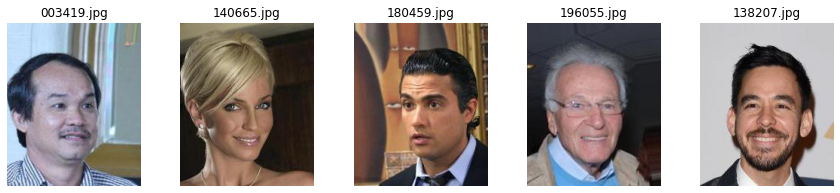

In [11]:
from os.path import join

def visualize(data_path, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n, filename in enumerate(np.random.choice(os.listdir(data_path), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img = plt.imread(join(data_path, filename))
        plt.imshow(img)
        plt.title(filename)
    plt.show()
    
visualize(DATA_PATH)

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [12]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    """
        Your code goes here.
    """
    
    g_batch_norm_0 = batch_norm(name='g_batch_norm_0')
    h_0_bn = g_batch_norm_0(h_in, is_training)
    h_0_a = lrelu(h_0_bn, name='g_lr_0')
    
    h_1 = deconv2d(h_0_a, output_shape=[BATCH_SIZE, 8, 8, 512], name='g_deconv2d_1')
    g_batch_norm_1 = batch_norm(name='g_batch_norm_1')
    h_1_bn = g_batch_norm_1(h_1, is_training)
    h_1_a = lrelu(h_1_bn, name='g_lr_1')
    h_1_a_dr = tf.nn.dropout(h_1_a, 0.5, name='g_dr_1')
    
    h_2 = deconv2d(h_1_a_dr, output_shape=[BATCH_SIZE, 16, 16, 256], name='g_deconv2d_2')
    g_batch_norm_2 = batch_norm(name='g_batch_norm_2')
    h_2_bn = g_batch_norm_2(h_2, is_training)
    h_2_a = lrelu(h_2_bn, name='g_lr_2')
    h_2_a_dr = tf.nn.dropout(h_2_a, 0.5, name='g_dr_2')
    
    h_3 = deconv2d(h_2_a_dr, output_shape=[BATCH_SIZE, 32, 32, 128], name='g_deconv2d_3')
    g_batch_norm_3 = batch_norm(name='g_batch_norm_3')
    h_3_bn = g_batch_norm_3(h_3, is_training)
    h_3_a = lrelu(h_3_bn, name='g_lr_3')  
    
    h_out = deconv2d(h_3_a, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

    return tf.nn.tanh(h_out)

In [13]:
# # ALTERNATIVE CODE 

# def generator(z, is_training, g_bnorms):
#     # Firstly let's reshape input vector into 3-d tensor. 
    
#     z_ = linear(z, GENERATOR_DENSE_SIZE * 2*2, 'g_h0_lin')
#     h_in = tf.reshape(z_, [-1, 2, 2, GENERATOR_DENSE_SIZE])
    
#     g_bnorm_1 = g_bnorms[0](h_in, train=is_training)
#     g_lrelu_1 = lrelu(g_bnorm_1,name="g_lrelu1")
#     g_deconv_1 = deconv2d(g_lrelu_1,[BATCH_SIZE, 4, 4, 256],name="g_deconv1")
    
#     g_bnorm_2 = g_bnorms[1](g_deconv_1, train=is_training)
#     g_lrelu_2 = lrelu(g_bnorm_2,name="g_lrelu2")
#     g_deconv_2 = deconv2d(g_lrelu_2,[BATCH_SIZE, 8, 8, 128],name="g_deconv2")
    
#     g_bnorm_3 = g_bnorms[2](g_deconv_2, train=is_training)
#     g_lrelu_3 = lrelu(g_bnorm_3,name="g_lrelu3")
#     g_deconv_3 = deconv2d(g_lrelu_3,[BATCH_SIZE, 16, 16, 64],name="g_deconv3")
    
#     g_bnorm_4 = g_bnorms[3](g_deconv_3, train=is_training)
#     g_lrelu_4 = lrelu(g_bnorm_4,name="g_lrelu4")
    
#     h_out = deconv2d(g_lrelu_4, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
#             name='g_out')

#     return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [14]:
def discriminator(image, is_training, batch_norms=None):
    """
        Your code goes here.
    """
    
    h_0 = conv2d(image, output_dim=32, name='d_conv2d_0')
    d_batch_norm_0 = batch_norm(name='d_batch_norm_0')
    h_0_bn = d_batch_norm_0(h_0, is_training)
    h_0_a = lrelu(h_0_bn, name='d_lr_0')
    h_0_p = tf.layers.average_pooling2d(h_0_a, pool_size=(2, 2), strides=2, name='d_pool_0')
    
    h_1 = conv2d(h_0_p, output_dim=64, name='d_conv2d_1')
    d_batch_norm_1 = batch_norm(name='d_batch_norm_1')
    h_1_bn = d_batch_norm_1(h_1, is_training)
    h_1_a = lrelu(h_1_bn, name='d_lr_1')
    h_1_p = tf.layers.average_pooling2d(h_1_a, pool_size=(2, 2), strides=2, name='d_pool_1')
    
    h_2 = conv2d(h_1_p, output_dim=128, name='d_conv2d_2')
    d_batch_norm_2 = batch_norm(name='d_batch_norm_2')
    h_2_bn = d_batch_norm_2(h_2, is_training)
    h_2_a = lrelu(h_2_bn, name='d_lr_2')
    h_2_p = tf.layers.average_pooling2d(h_2_a, pool_size=(2, 2), strides=2, name='d_pool_2')
    
    h_flat = tf.layers.flatten(h_2_p)
    h_linear = linear(h_flat, 256, 'd_h_linear')
    h_linear_a = lrelu(h_linear, name='d_lr_4')
    
    linear_out = linear(h_linear_a, 1, 'linear_out')
    
    return tf.nn.sigmoid(linear_out), linear_out

In [15]:
# # ALTERNATIVE CODE 
# tf.reset_default_graph()
# is_training = tf.placeholder(tf.bool, name='is_training')

# with tf.variable_scope("G") as scope:
#     z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
#     g_bnorms = [batch_norm(name="g_bnorm1"), batch_norm(name="g_bnorm2"), batch_norm(name="g_bnorm3"), 
#                 batch_norm(name="g_bnorm4")]
#     G = generator(z, is_training, g_bnorms)

# with tf.variable_scope('D') as scope:
#     images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
#     d_bnorms = [batch_norm(name="d_bnorm1"), batch_norm(name="d_bnorm2"), batch_norm(name="d_bnorm3"),
#                batch_norm(name="d_bnorm4")]
#     D_real, D_real_logits = discriminator(images, is_training, d_bnorms)
#     scope.reuse_variables()
#     D_fake, D_fake_logits = discriminator(G, is_training, d_bnorms)

Now let's define generator and discriminator.

In [16]:
import tensorflow as tf
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [17]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = -tf.reduce_mean(tf.log(D_real + 1e-30))

d_loss_fake = -tf.reduce_mean(tf.log(1 - D_fake + 1e-30))

d_loss = d_loss_real + d_loss_fake

g_loss = -tf.reduce_mean(tf.log(D_fake + 1e-30))

In [18]:
# ALTERNATIVE CODE 

# d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))

# d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))

# d_loss = d_loss_real + d_loss_fake

# g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [19]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

In [20]:
DATA_PATH

'/content/img_align_celeba'

Load data:

In [21]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))[:32768]
assert(len(data) > 0), "Length of training data should be more than zero"



Functions for training and evaluations.

In [22]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [23]:
# get images into the right shape
from skimage.transform import resize

def get_resize_transform_image(image_path):
    return transform(resize(plt.imread(image_path), 
                            (IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), 
                            preserve_range=True, 
                            mode='reflect', 
                            anti_aliasing=True))
    


In [24]:
image_path = data[2]
c = plt.imread(image_path)
print(c.shape)
d = get_resize_transform_image(image_path)
print(d.shape)

(218, 178, 3)
(64, 64, 3)


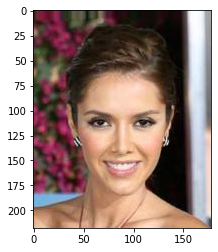

In [25]:
plt.imshow(c)

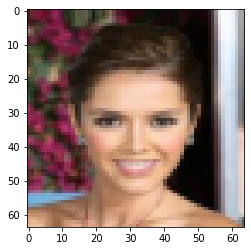

In [26]:
plt.imshow(inverse_transform(d))

In [40]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=1, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_resize_transform_image(batch_file) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
              print('saved')
              samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
              if not os.path.exists(sample_dir): 
                os.makedirs(sample_dir)
              save_images(samples, [MERGE_X, MERGE_Y],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                
                
              print("Sample")


In [41]:
# This training could take a while 12 hours or more 

with tf.Session() as sess:
    train(sess, save_dir='checkpoint', max_to_keep=20)

Epoch: [ 0] [   0/ 512] time: 5.5384, d_loss: 1.38637304, g_loss: 0.69338030
Epoch: [ 0] [   1/ 512] time: 6.9067, d_loss: 1.38647163, g_loss: 0.69328135
Epoch: [ 0] [   2/ 512] time: 8.2879, d_loss: 1.38666713, g_loss: 0.69305110
Epoch: [ 0] [   3/ 512] time: 9.6485, d_loss: 1.38666153, g_loss: 0.69228351
Epoch: [ 0] [   4/ 512] time: 10.9985, d_loss: 1.38659143, g_loss: 0.69112104
Epoch: [ 0] [   5/ 512] time: 12.3226, d_loss: 1.38713241, g_loss: 0.68953538
Epoch: [ 0] [   6/ 512] time: 13.6723, d_loss: 1.38516700, g_loss: 0.68816525
Epoch: [ 0] [   7/ 512] time: 15.0127, d_loss: 1.38075209, g_loss: 0.68709069
Epoch: [ 0] [   8/ 512] time: 16.3239, d_loss: 1.37140000, g_loss: 0.68650514
Epoch: [ 0] [   9/ 512] time: 17.6604, d_loss: 1.37732208, g_loss: 0.68758273
Epoch: [ 0] [  10/ 512] time: 19.0037, d_loss: 1.37702143, g_loss: 0.68934160
Epoch: [ 0] [  11/ 512] time: 20.3161, d_loss: 1.37655997, g_loss: 0.69199729
Epoch: [ 0] [  12/ 512] time: 21.6214, d_loss: 1.38303494, g_loss: 0

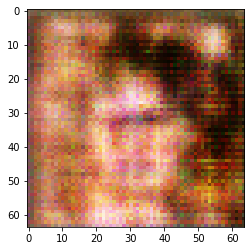

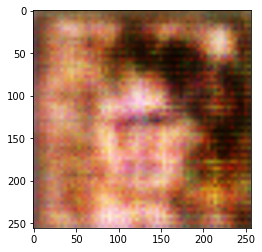

In [55]:
plt.figure()
plt.imshow(inverse_transform(samples[0]))
plt.figure()
plt.imshow(resize(inverse_transform(samples[0]),(256,256,3)))

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [45]:
z1 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)

batchz = []
for i in range(64):
    alpha = i/63.0
    batchz.append(z1*alpha + (1-alpha)*z2)

batchz = np.array(batchz).astype(np.float32)
print(batchz.shape)

with tf.Session() as sess:
    print("Reading checkpoints...")
    load(sess, 'checkpoint')
    print("Loaded checkpoints")
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

(64, 100)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
Loaded checkpoints


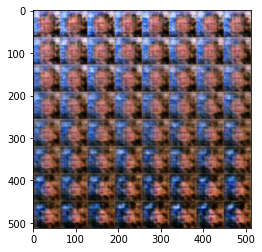

In [46]:
plt.imshow(inverse_transform(merge(samples, [8, 8])))

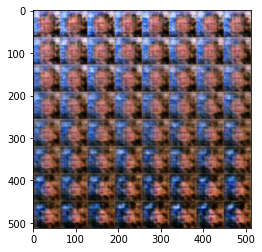

In [47]:
plt.imshow(inverse_transform(merge(samples, [8, 8])))

In [48]:
batchz = np.random.uniform(-1, 1, [64,Z_DIM]).astype(np.float32)

print(batchz.shape)

with tf.Session() as sess:
    print("Reading checkpoints...")
    load(sess, 'checkpoint')
    print("Loaded checkpoints")
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

(64, 100)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
Loaded checkpoints


In [49]:
resized_samples = np.array([resize(sample,(128,128,3)) for sample in samples])

In [50]:
smiling = [8,9,13,20,21]
not_smiling = [1,19,25,50,51]

In [51]:
smiling_z = np.array([batchz[i] for i in smiling])
smiling_samples = np.array([resized_samples[i] for i in smiling])
not_smiling_z = np.array([batchz[i] for i in not_smiling])
not_smiling_samples = np.array([resized_samples[i] for i in not_smiling])

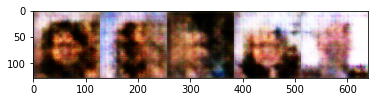

In [52]:
plt.imshow(inverse_transform(merge(smiling_samples, [1, 5])))

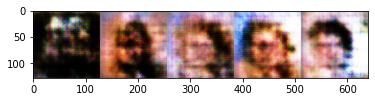

In [53]:
plt.imshow(inverse_transform(merge(not_smiling_samples, [1, 5])))

In [ ]:
smile_vector = np.mean(smiling_z,axis=0) - np.mean(not_smiling_z,axis=0)
smile_vector.shape

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

In [60]:
batchz = np.random.uniform(-1, 1, [64,Z_DIM]).astype(np.float32)

print(batchz.shape)

with tf.Session() as sess:
    print("Reading checkpoints...")
    load(sess, 'checkpoint')
    print("Loaded checkpoints")
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

(64, 100)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
Loaded checkpoints


In [61]:
resized_samples = np.array([resize(sample,(128,128,3)) for sample in samples])

In [62]:
smiling = [8,9,13,20,21]
not_smiling = [1,19,25,50,51]

In [63]:
smiling_z = np.array([batchz[i] for i in smiling])
smiling_samples = np.array([resized_samples[i] for i in smiling])
not_smiling_z = np.array([batchz[i] for i in not_smiling])
not_smiling_samples = np.array([resized_samples[i] for i in not_smiling])

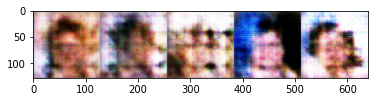

In [64]:
plt.imshow(inverse_transform(merge(smiling_samples, [1, 5])))

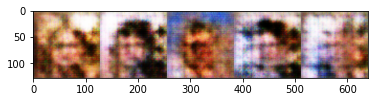

In [65]:
plt.imshow(inverse_transform(merge(not_smiling_samples, [1, 5])))

In [66]:
smile_vector = np.mean(smiling_z,axis=0) - np.mean(not_smiling_z,axis=0)
smile_vector.shape

(100,)

In [67]:
batchz = np.random.uniform(-1, 1, [64,Z_DIM]).astype(np.float32)
for i in range(32):
    batchz[2*i+1] = batchz[2*i]+smile_vector

print(batchz.shape)

with tf.Session() as sess:
    print("Reading checkpoints...")
    load(sess, 'checkpoint')
    print("Loaded checkpoints")
    smiling_samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

(64, 100)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
Loaded checkpoints


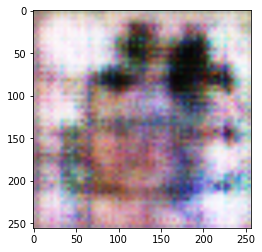

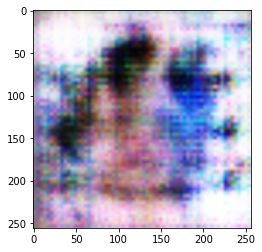

In [68]:
i=6
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i]),(256,256,3)))
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i+1]),(256,256,3)))

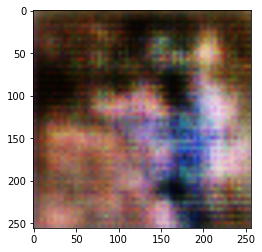

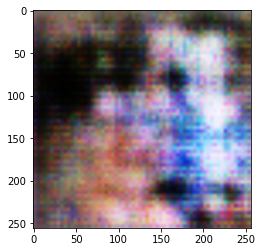

In [69]:
i=8
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i]),(256,256,3)))
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i+1]),(256,256,3)))

If faces looks really cool, add bonus 1 point to your score.